In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
PATH = 'drive/MyDrive/trab final de IA/acidentesDataSet/acidentesDataSet/Accident -Detection/'
TRAIN_SIZE = 0.8
BATCH_SIZE = 8
SHUFFLE=True

train_transforms = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(180),
    transforms.ToTensor()
])

full_train = datasets.ImageFolder(PATH, transform = train_transforms)
full_test = datasets.ImageFolder(PATH, transform = test_transforms)

index = np.arange(len(full_train))

np.random.shuffle(index)

split = int(len(full_train)*TRAIN_SIZE)

train_indexes = index[:split]
test_indexes = index[split:]

train_dataset = torch.utils.data.Subset(full_train, train_indexes)
test_dataset = torch.utils.data.Subset(full_test, test_indexes)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

3918
980


In [ ]:
print(f'Class distribution - train dataset: {dict(Counter(full_train.targets[i] for i in train_indexes))}')
print(f'Class distribution - test dataset: {dict(Counter(full_train.targets[i] for i in test_indexes))}')

Class distribution - train dataset: {1: 1908, 0: 2010}
Class distribution - test dataset: {1: 490, 0: 490}


In [ ]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
single_train_images, single_train_labels = next(iter(train_loader))

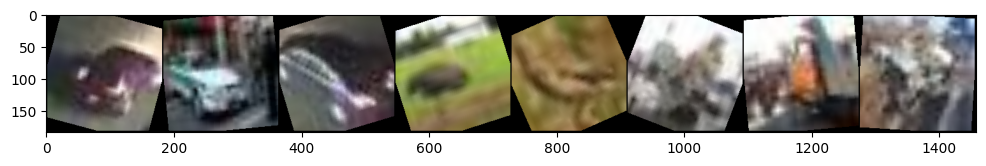

In [ ]:
imshow(torchvision.utils.make_grid(single_train_images, 8))
print(torch.reshape(single_train_labels, (-1,8)))

In [ ]:
single_test_images, single_test_labels = next(iter(test_loader))

tensor([[0, 1, 0, 0, 0, 1, 1, 1]])


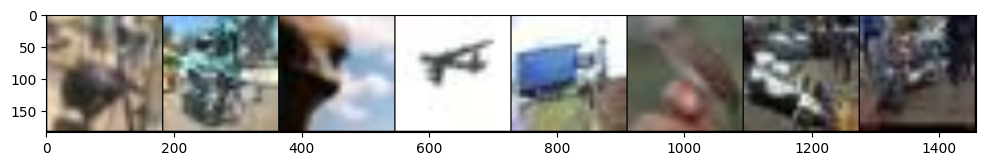

tensor([[0, 1, 0, 0, 1, 0, 1, 1]])


In [ ]:
imshow(torchvision.utils.make_grid(single_test_images, 8))
print(torch.reshape(single_test_labels, (-1,8)))

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(28224, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x.float())))
        x = self.pool2(F.relu(self.conv2(x.float())))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

In [ ]:
cnn = CNN().to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [ ]:
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
for epoch in range(10):  # loop over the dataset multiple times
    cnn.train()
    running_loss = 0.0
    correct_count = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)[:, 0].to(device)
        loss = criterion(outputs.type(torch.float), labels.type(torch.float))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        predicted = (outputs >= 0.5).type(torch.int).to(device)
        correct_count += (labels == predicted).sum().item()
        del(inputs)
        del(labels)
        del(outputs)
        del(predicted)
    train_loss_values.append(running_loss / len(train_dataset))
    train_accuracy_values.append(correct_count / len(train_dataset))
    cnn.eval()
    running_loss = 0.0
    correct_count = 0.0
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(inputs)[:, 0].to(device)
        loss = criterion(outputs.type(torch.float), labels.type(torch.float))
        running_loss += loss.item() * labels.size(0)
        predicted = (outputs >= 0.5).type(torch.int).to(device)
        correct_count += (labels == predicted).sum().item()
        del(inputs)
        del(labels)
        del(outputs)
        del(predicted)
    test_loss_values.append(running_loss / len(test_dataset))
    test_accuracy_values.append(correct_count / len(test_dataset))


print('Finished Training')

Finished Training


In [ ]:
torch.save(cnn.state_dict(), 'drive/MyDrive/trab final de IA/model')
del(cnn)

In [ ]:
cnn = CNN().to(device)
cnn.load_state_dict(torch.load('drive/MyDrive/trab final de IA/model'))

<All keys matched successfully>

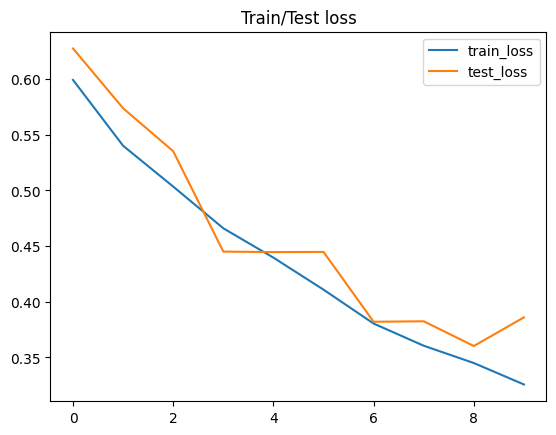

Final epoch - train loss value: 0.3257714813387838
Final epoch - test loss value: 0.38602952683458525


In [ ]:
plt.plot(train_loss_values, label='train_loss')
plt.plot(test_loss_values, label='test_loss')
plt.legend()
plt.title('Train/Test loss')
plt.show()
print(f'Final epoch - train loss value: {train_loss_values[-1]}')
print(f'Final epoch - test loss value: {test_loss_values[-1]}')

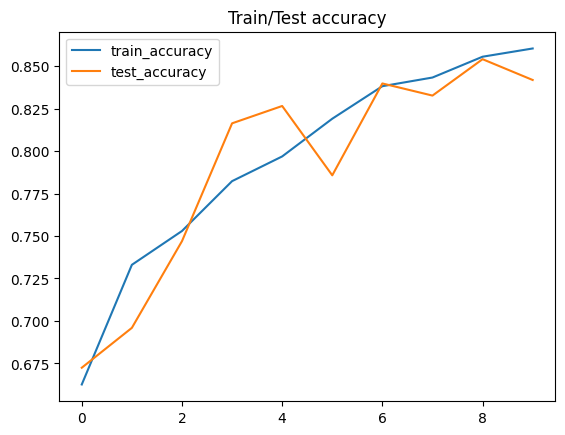

Final epoch - train accuracy value: 0.8603879530372639
Final epoch - test accuracy value: 0.8418367346938775


In [ ]:
plt.plot(train_accuracy_values, label='train_accuracy')
plt.plot(test_accuracy_values, label='test_accuracy')
plt.title('Train/Test accuracy')
plt.legend()
plt.show()
print(f'Final epoch - train accuracy value: {train_accuracy_values[-1]}')
print(f'Final epoch - test accuracy value: {test_accuracy_values[-1]}')

Test Precision: 0.8496868475991649
Test Recall: 0.8343313373253493
Test F1-Score: 0.841939083807398


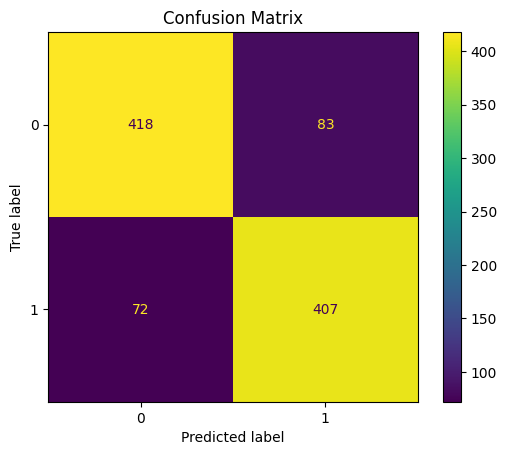

In [ ]:
TP = 0
FP = 0
TN = 0
FN = 0
cnn.eval()
for i, data in enumerate(test_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(inputs)[:, 0].to(device)
        loss = criterion(outputs.type(torch.float), labels.type(torch.float))
        running_loss += loss.item() * labels.size(0)
        predicted = (outputs >= 0.5).type(torch.int).to(device)
        positive_indexes = (predicted==1)
        positive_len = int(positive_indexes.sum())
        negative_indexes = (predicted==0)
        negative_len = int(negative_indexes.sum())
        TP_ = int((labels[positive_indexes] == predicted[positive_indexes]).sum())
        FP_ = positive_len - TP_
        TN_ = int((labels[negative_indexes] == predicted[negative_indexes]).sum().type(torch.int))
        FN_ = negative_len - TN_
        TP += TP_
        FP += FP_
        TN += TN_
        FN += FN_
        del(inputs)
        del(labels)
        del(outputs)
        del(predicted)

precision = TP/(TP+FP)
recall = TN/(TN+FN)
f1_score = (2*precision*recall)/(precision+recall)
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print(f'Test F1-Score: {f1_score}')
confusion_matrix = np.array([[TN, FN], [FP, TP]])
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [ ]:
single_test_images, single_test_labels = next(iter(test_loader))

In [ ]:
single_test_outputs = cnn(single_test_images.type(torch.float).to(device))
single_test_predicts = (single_test_outputs >= 0.5).type(torch.int)

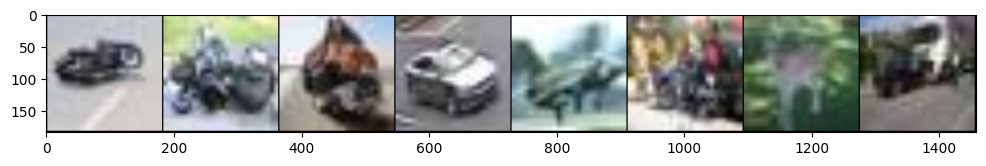

Real labels:
tensor([[1, 1, 1, 0, 0, 1, 0, 1]])
Predicted labels:
tensor([[0, 1, 1, 0, 0, 1, 0, 1]], device='cuda:0', dtype=torch.int32)


In [ ]:
imshow(torchvision.utils.make_grid(single_test_images, 8))
print('Real labels:')
print(torch.reshape(single_test_labels, (-1, 8)))
print('Predicted labels:')
print(torch.reshape(single_test_predicts, (-1, 8)))